In [1]:
from collections import Counter
import random
from typing import Any, Dict, List, Optional, Tuple

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

import utilities.plotting_style as pstyle

pstyle.apply_style() 

PlotFonts(base=None, bold=None)

In [2]:
def init_simulation_state(
    *,
    all_stickers: List[int],
    free_stickers: int,
    len_album: int,
    rng: random.Random,
) -> Dict[str, Any]:
    """
    Initialize per-simulation mutable state.
    """
    album = set(rng.sample(all_stickers, free_stickers))
    dupes = Counter()

    state: Dict[str, Any] = {
        "album": album,
        "dupes": dupes,
        "n_packets": 0,
        "n_trades": 0,
        "cost_packets": 0.0,
        "cost_postage": 0.0,
        "stickers_from_packets": 0,
        "stickers_from_trade": 0,
        "packet_gains": [],              # one entry per packet opened
        "trade_gains_after_packet": [],  # one entry per packet opened
        "missing_count": len_album - len(album),
    }
    return state

In [3]:
def buy_and_apply_packets(
    *,
    state: Dict[str, Any],
    all_stickers: List[int],
    len_packet: int,
    packet_price: float,
    len_album: int,
    rng: random.Random,
    batch_size: int = 1,
) -> None:
    """
    Buy/open `batch_size` packets, updating album/dupes/costs and per-packet gains.

    Substance is kept the same:
    - packet = rng.sample(all_stickers, len_packet)  # no dupes within a packet
    - new_dupes = [s for s in packet if s in album]
    - dupes.update(new_dupes); album.update(packet)
    - packet_gain = len_packet - len(new_dupes)
    """
    album = state["album"]
    dupes: Counter = state["dupes"]

    for _ in range(batch_size):
        packet = rng.sample(all_stickers, len_packet)
        state["n_packets"] += 1
        state["cost_packets"] += packet_price

        new_dupes = [s for s in packet if s in album]
        dupes.update(new_dupes)
        album.update(packet)

        packet_gain = len_packet - len(new_dupes)
        state["stickers_from_packets"] += packet_gain

        state["packet_gains"].append(packet_gain)
        state["trade_gains_after_packet"].append(0)

    state["missing_count"] = len_album - len(album)

In [4]:
def can_trade_now(
    *,
    dupes: Counter,
    min_trade: float,
    exchange_efficiency: float,
) -> bool:
    """
    Keep substance the same as your current guard:
        total_dupes = len(dupes)  # distinct dupes
        total_dupes >= (min_trade / exchange_efficiency)
    """
    total_dupes = len(dupes)
    return total_dupes >= (min_trade / exchange_efficiency)

In [5]:
def execute_one_trade(
    *,
    state: Dict[str, Any],
    all_stickers: List[int],
    len_album: int,
    order_stickers: int,
    max_trade: int,
    min_trade: float,
    exchange_efficiency: float,
    postage_cost: float,
    rng: random.Random,
) -> bool:
    """
    Attempt a single trade (mutates state). Returns True if a trade was executed, else False.

    Substance is kept the same:
    - trade_size = min(random.choice(range(1, total_dupes+1)), max_trade, missing_count)
    - still_missing = list(set(all_stickers) - album)
    - trade_size = min(trade_size, len(still_missing))
    - new_from_trade = random.sample(still_missing, trade_size)
    - trade_away = random.sample(list(dupes.keys()), trade_size)  # distinct rule
    - cost_postage += postage_cost; n_trades += 1
    - album.update(new_from_trade)
    - dupes.subtract(trade_away); dupes += Counter()
    - trade_gain tracked as len(new_from_trade)
    - attributed to trade_gains_after_packet[-1]
    """
    album = state["album"]
    dupes: Counter = state["dupes"]
    missing_count = state["missing_count"]

    if missing_count <= order_stickers:
        return False

    if not can_trade_now(dupes=dupes, min_trade=min_trade, exchange_efficiency=exchange_efficiency):
        return False

    total_dupes = len(dupes)

    trade_size = min(rng.choice(range(1, total_dupes + 1)), max_trade, missing_count)

    still_missing = list(set(all_stickers) - album)
    trade_size = min(trade_size, len(still_missing))  # tiny safety

    if trade_size <= 0:
        return False

    new_from_trade = rng.sample(still_missing, trade_size)
    trade_away = rng.sample(list(dupes.keys()), trade_size)

    state["cost_postage"] += postage_cost
    state["n_trades"] += 1

    trade_gain = len(new_from_trade)
    state["stickers_from_trade"] += trade_gain

    # attribute all trades to the most recently opened packet index
    if state["trade_gains_after_packet"]:
        state["trade_gains_after_packet"][-1] += trade_gain

    album.update(new_from_trade)
    dupes.subtract(trade_away)
    state["dupes"] = dupes + Counter()  # clean zeros/negatives

    state["missing_count"] = len_album - len(album)
    return True

In [6]:
def trade_after_buy(
    *,
    state: Dict[str, Any],
    all_stickers: List[int],
    len_album: int,
    order_stickers: int,
    max_trade: int,
    min_trade: float,
    exchange_efficiency: float,
    postage_cost: float,
    rng: random.Random,
    max_trades_per_cycle: Optional[int] = 3,
) -> None:
    """
    After buying (one packet or a batch), attempt trades:
    - up to `max_trades_per_cycle` trades OR
    - stop early if missing_count <= order_stickers OR can't trade

    If you want "until the missing threshold" with no cap, pass max_trades_per_cycle=None.
    """
    if max_trades_per_cycle is None:
        while True:
            did_trade = execute_one_trade(
                state=state,
                all_stickers=all_stickers,
                len_album=len_album,
                order_stickers=order_stickers,
                max_trade=max_trade,
                min_trade=min_trade,
                exchange_efficiency=exchange_efficiency,
                postage_cost=postage_cost,
                rng=rng,
            )
            if not did_trade:
                break
        return

    for _ in range(max_trades_per_cycle):
        did_trade = execute_one_trade(
            state=state,
            all_stickers=all_stickers,
            len_album=len_album,
            order_stickers=order_stickers,
            max_trade=max_trade,
            min_trade=min_trade,
            exchange_efficiency=exchange_efficiency,
            postage_cost=postage_cost,
            rng=rng,
        )
        if not did_trade:
            break

In [7]:
def compute_crossover_indices(
    *,
    packet_gains: List[int],
    trade_gains_after_packet: List[int],
) -> Tuple[Optional[int], Optional[int]]:
    """
    Contribution-based crossover indices (same logic as you used):
    - start_trading: first i where (trade_gain - packet_gain) >= 0
    - stop_buying: last i where (trade_gain - packet_gain) < 0
    """
    delta = [t - p for p, t in zip(packet_gains, trade_gains_after_packet)]
    start_trade_idx = next((i for i, d in enumerate(delta) if d >= 0), None)
    last_buy_dominant_idx = next((i for i in range(len(delta) - 1, -1, -1) if delta[i] < 0), None)
    return start_trade_idx, last_buy_dominant_idx

In [30]:
def simulate_one(
    *,
    len_album: int,
    free_stickers: int,
    len_packet: int,
    packet_price: float,
    postage_cost: float,
    order_stickers: int,
    max_trade: int,
    min_trade: float,
    exchange_efficiency: float,
    batch_size: int = 1,
    max_trades_per_cycle: Optional[int] = 3,
    seed: Optional[int] = None,
) -> Dict[str, Any]:
    """
    Run a single simulation and return one result record.

    NOTE: This keeps the substance of your current logic:
    - stop condition: while missing_count > order_stickers
    - trading guard: total_dupes < (min_trade / exchange_efficiency) -> no trade
    - 1-for-1 trading mechanics (trade_size used for both away and received)
    - packet/trade contributions tracked
    - crossover indices computed from per-packet gains
    """
    rng = random.Random(seed)
    all_stickers = list(range(len_album))

    state = init_simulation_state(
        all_stickers=all_stickers,
        free_stickers=free_stickers,
        len_album=len_album,
        rng=rng,
    )

    while state["missing_count"] > order_stickers:
        buy_and_apply_packets(
            state=state,
            all_stickers=all_stickers,
            len_packet=len_packet,
            packet_price=packet_price,
            len_album=len_album,
            rng=rng,
            batch_size=batch_size,
        )

        trade_after_buy(
            state=state,
            all_stickers=all_stickers,
            len_album=len_album,
            order_stickers=order_stickers,
            max_trade=max_trade,
            min_trade=min_trade,
            exchange_efficiency=exchange_efficiency,
            postage_cost=postage_cost,
            rng=rng,
            max_trades_per_cycle=max_trades_per_cycle,
        )

    start_trading, stop_buying = compute_crossover_indices(
        packet_gains=state["packet_gains"],
        trade_gains_after_packet=state["trade_gains_after_packet"],
    )

    # keep your accounting for ordered stickers (substance preserved)
    total_ordered = len_album - state["stickers_from_packets"] - state["stickers_from_trade"] - free_stickers

    params_used = {
    "len_album": len_album,
    "free_stickers": free_stickers,
    "len_packet": len_packet,
    "packet_price": packet_price,
    "postage_cost": postage_cost,
    "order_stickers": order_stickers,
    "max_trade": max_trade,
    "min_trade": min_trade,
    "exchange_efficiency": exchange_efficiency,
    "batch_size": batch_size,
    "max_trades_per_cycle": max_trades_per_cycle,
    }
    
    return {
        **params_used,
        "num_packets": state["n_packets"],
        "buy_cost": state["cost_packets"],
        "total_from_packets": state["stickers_from_packets"],
        "num_trades": state["n_trades"],
        "trade_cost": state["cost_postage"],
        "total_from_trades": state["stickers_from_trade"],
        "total_cost": state["cost_packets"] + state["cost_postage"],
        "total_ordered": total_ordered,
        "start_trading": start_trading,
        "stop_buying": stop_buying,
        # optional debug/timeline outputs (useful later, easy to drop in a class)
        "packet_gains": state["packet_gains"],
        "trade_gains_after_packet": state["trade_gains_after_packet"],
    }

In [9]:
def run_simulations(
    *,
    n_simulations: int,
    len_album: int,
    free_stickers: int,
    len_packet: int,
    packet_price: float,
    postage_cost: float,
    order_stickers: int,
    max_trade: int,
    min_trade: float,
    exchange_efficiency: float,
    batch_size: int = 1,
    max_trades_per_cycle: Optional[int] = 3,
    seed: Optional[int] = None,
) -> List[Dict[str, Any]]:
    """
    Convenience wrapper: runs simulate_one() n_simulations times and returns list of dict records.
    (You can convert to a DataFrame in your notebook.)
    """
    rng = random.Random(seed)
    records: List[Dict[str, Any]] = []

    for _ in range(n_simulations):
        # derive per-sim seed for reproducibility while keeping sims independent
        sim_seed = rng.randrange(1_000_000_000) if seed is not None else None
        rec = simulate_one(
            len_album=len_album,
            free_stickers=free_stickers,
            len_packet=len_packet,
            packet_price=packet_price,
            postage_cost=postage_cost,
            order_stickers=order_stickers,
            max_trade=max_trade,
            min_trade=min_trade,
            exchange_efficiency=exchange_efficiency,
            batch_size=batch_size,
            max_trades_per_cycle=max_trades_per_cycle,
            seed=sim_seed,
        )
        records.append(rec)

    return records

In [ ]:
len_album = 1_000
len_packet = 5
order_stickers = 25
free_stickers = 6
exchange_efficiency = .1
packet_price = 0.8
postage_cost = 0.5
max_trade = 10
n_simulations = 10_000

trade_size = list(range(1, 11))
buy_cost_per_sticker = packet_price / len_packet
trade_cost_per_sticker = [postage_cost / x for x in trade_size]

min_trade = min([i for (i, x) in zip(trade_size, trade_cost_per_sticker) if x <= buy_cost_per_sticker])
print(min_trade)

4


In [31]:
records = run_simulations(
    n_simulations=n_simulations,
    len_album=len_album,
    free_stickers=free_stickers,
    len_packet=len_packet,
    packet_price=packet_price,
    postage_cost=postage_cost,
    order_stickers=order_stickers,
    max_trade=max_trade,
    min_trade=min_trade,
    exchange_efficiency=exchange_efficiency,
    batch_size=1,              # <-- set to 1 to disable batching
    max_trades_per_cycle=3,     # <-- set to None to trade until threshold / can't trade
    seed=42,
)

In [32]:
results_df = pd.DataFrame(records).drop(columns=["packet_gains", "trade_gains_after_packet"])
results_df.head()

,len_album,free_stickers,len_packet,packet_price,postage_cost,order_stickers,max_trade,min_trade,exchange_efficiency,batch_size,...,num_packets,buy_cost,total_from_packets,num_trades,trade_cost,total_from_trades,total_cost,total_ordered,start_trading,stop_buying
0,1000,6,5,0.8,0.5,25,10,4,0.25,1,...,197,157.6,489,68,34.0,482,191.6,23,37,182
1,1000,6,5,0.8,0.5,25,10,4,0.25,1,...,196,156.8,524,53,26.5,449,183.3,21,35,184
2,1000,6,5,0.8,0.5,25,10,4,0.25,1,...,198,158.4,505,70,35.0,473,193.4,16,35,187
3,1000,6,5,0.8,0.5,25,10,4,0.25,1,...,197,157.6,506,63,31.5,470,189.1,18,36,195
4,1000,6,5,0.8,0.5,25,10,4,0.25,1,...,196,156.8,499,63,31.5,472,188.3,23,35,185


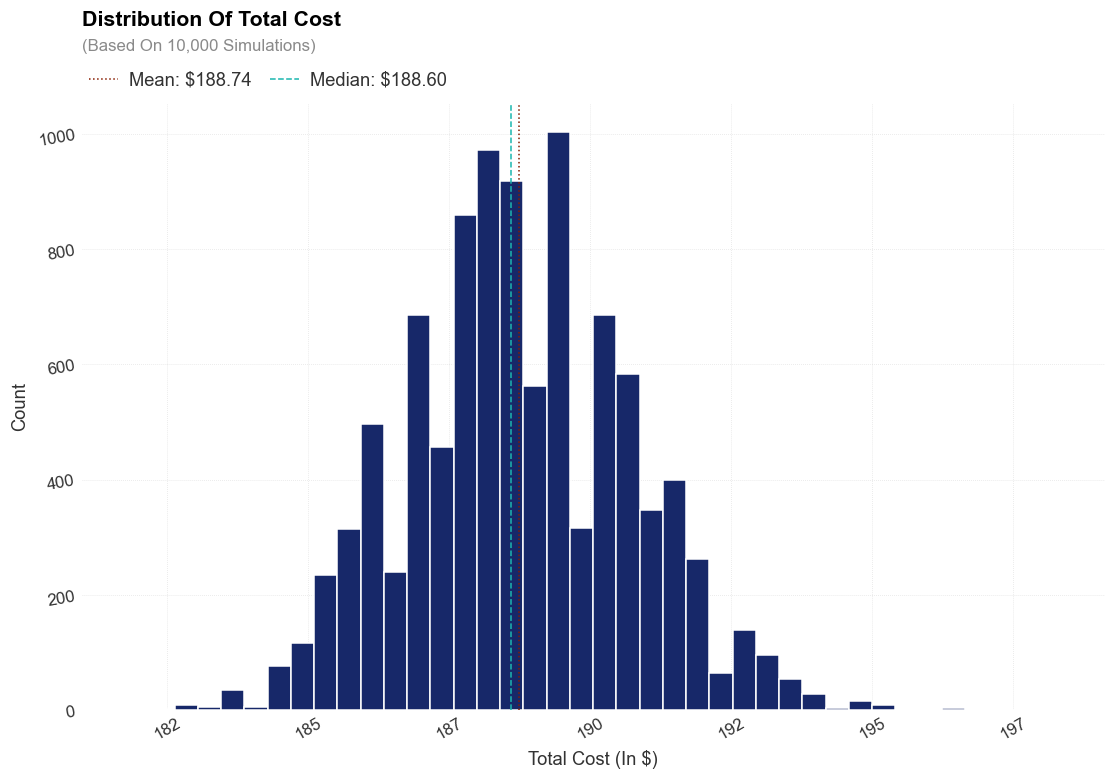

In [25]:
fig, ax = plt.subplots()

mean_cost = results_df["total_cost"].mean()
median_cost = results_df["total_cost"].median()

ax.hist(results_df["total_cost"], bins=40)
ax.axvline(mean_cost, linewidth=1, linestyle="dotted", color="#881C00FF", label=f"Mean: ${mean_cost:,.2f}")
ax.axvline(median_cost, linewidth=1, linestyle="dashed", color="#1BB6AFFF", label=f"Median: ${median_cost:,.2f}")

pstyle.set_title(ax, "Distribution of Total Cost", f"(based on {n_simulations:,} simulations)")
ax.set_xlabel("Total Cost (in $)")
ax.set_ylabel("Count")

ax.legend(frameon=False)
pstyle.style_plot(ax, format_thousands_axis="x")

plt.show()

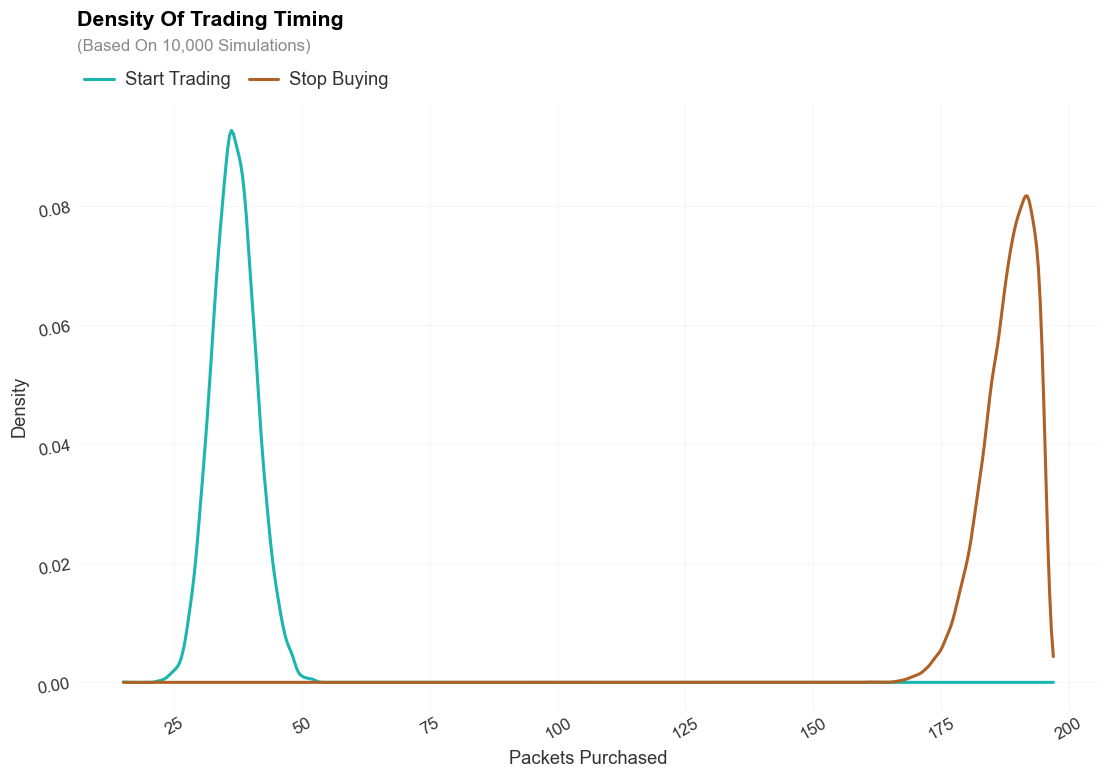

In [26]:
x1 = results_df["start_trading"].dropna().to_numpy()
x2 = results_df["stop_buying"].dropna().to_numpy()

# x-grid for plotting
xmin = min(x1.min(), x2.min())
xmax = max(x1.max(), x2.max())
xs = np.linspace(xmin, xmax, 500)

kde_start = gaussian_kde(x1)
kde_stop = gaussian_kde(x2)

fig, ax = plt.subplots()
ax.plot(xs, kde_start(xs), label="Start Trading", color = '#1BB6AFFF')
ax.plot(xs, kde_stop(xs), label="Stop Buying", color = '#AF6125FF') 

pstyle.set_title(ax, "Density of Trading Timing", f"(based on {n_simulations:,} simulations)")
ax.set_xlabel("Packets Purchased")
ax.set_ylabel("Density")

ax.legend(frameon=False)
pstyle.style_plot(ax, format_thousands_axis="x")

plt.show()

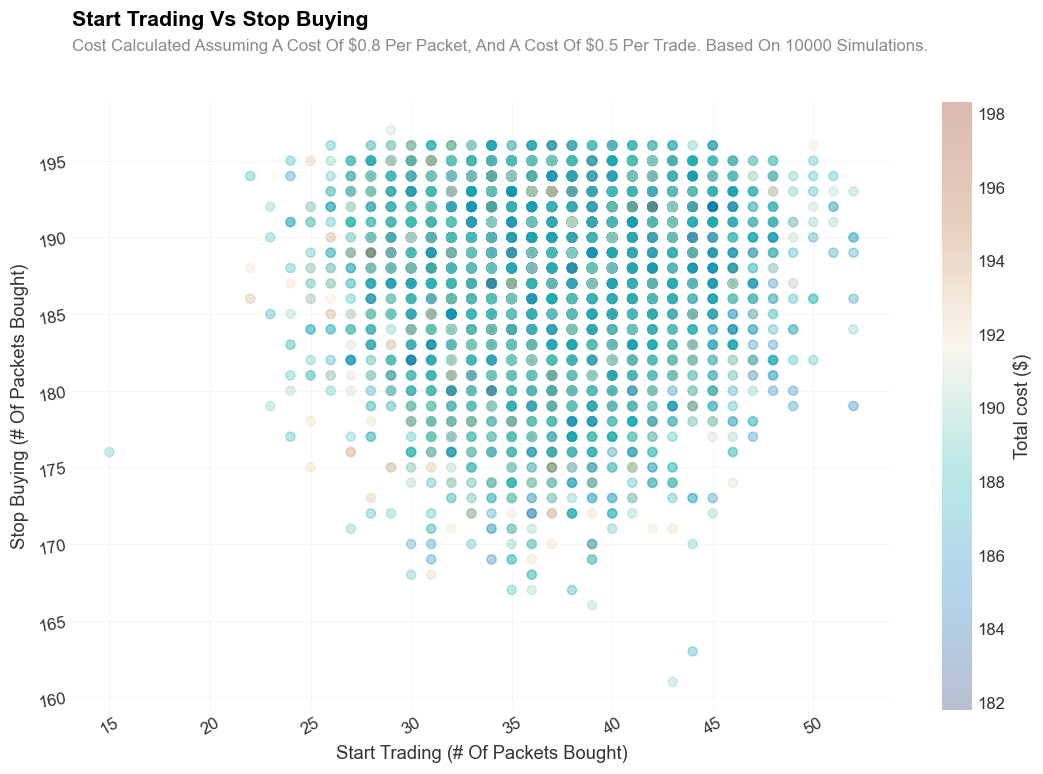

In [27]:
fig, ax = plt.subplots()

sc = ax.scatter(
    results_df["start_trading"],
    results_df["stop_buying"],
    c=results_df["total_cost"],
    alpha=0.3,
)

pstyle.set_title(ax, "Start trading vs stop buying", f"Cost calculated assuming a cost of \\${packet_price} per packet, and a cost of \\${postage_cost} per trade. Based on {n_simulations} simulations.")
ax.set_xlabel("Start trading (# of packets bought)")
ax.set_ylabel("Stop Buying (# of packets bought)")

pstyle.style_plot(ax, format_thousands_axis=None)  # or "x"/"y" if you want commas on axes too

cbar = fig.colorbar(sc, ax=ax)
cbar.set_label("Total cost ($)")

plt.show()

In [28]:
g = (
    results_df
    .dropna(subset=["start_trading", "total_cost"])
    .groupby("start_trading")["total_cost"]
    .agg(n="count", mean="mean", std="std")
    .reset_index()
    .sort_values("start_trading")
)

# 95% CI for the mean: mean ± 1.96 * (std / sqrt(n))
se = g["std"] / np.sqrt(g["n"])
g["ci_low"] = g["mean"] - 1.64 * se
g["ci_high"] = g["mean"] + 1.64 * se

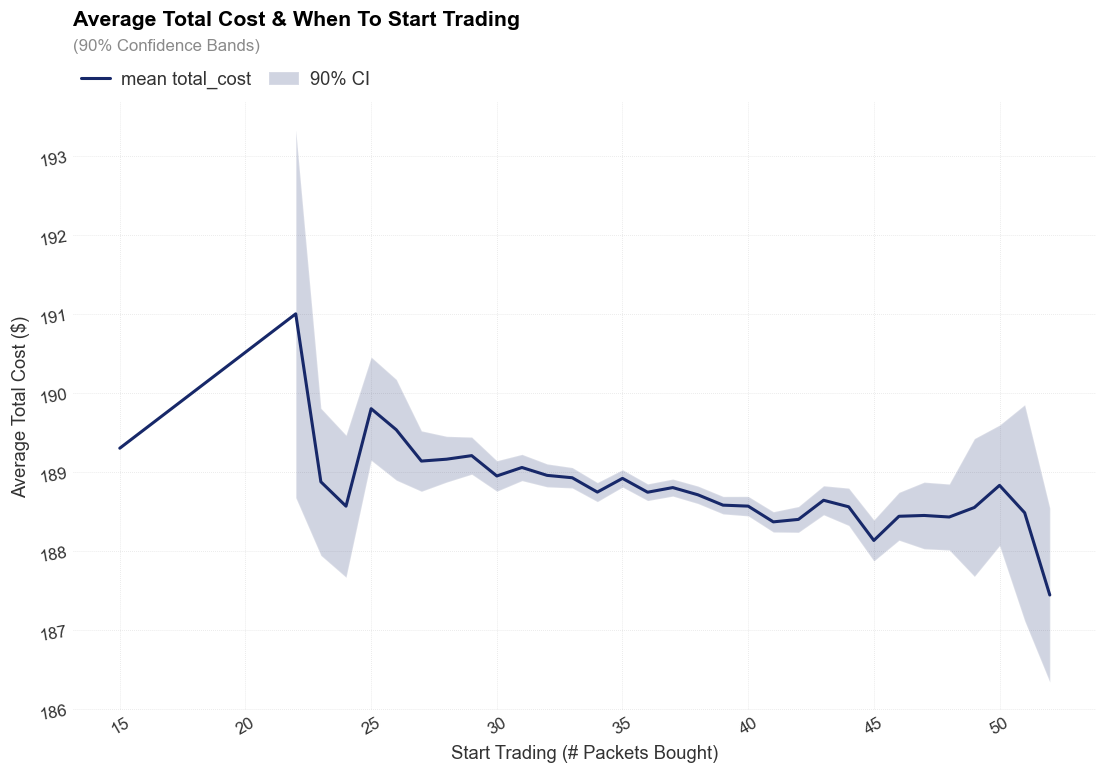

In [29]:

fig, ax = plt.subplots()

ax.plot(g["start_trading"], g["mean"], label="mean total_cost")
ax.fill_between(g["start_trading"], g["ci_low"], g["ci_high"], alpha=0.2, label="90% CI")

pstyle.set_title(ax, "Average Total Cost & When to Start Trading", "(90% confidence bands)")
ax.set_xlabel("Start Trading (# Packets bought)")
ax.set_ylabel("Average Total Cost ($)")

ax.legend(frameon=False)
pstyle.style_plot(ax, format_thousands_axis="y")

plt.show()

In [38]:
len_album_values = list(range(700, 1201, 100))
n_per_value = 2000

all_records = []
for L in len_album_values:
    records = run_simulations(
        n_simulations=n_per_value,
        len_album=L,
        free_stickers=free_stickers,
        len_packet=len_packet,
        packet_price=packet_price,
        postage_cost=postage_cost,
        order_stickers=order_stickers,
        max_trade=max_trade,
        min_trade=min_trade,
        exchange_efficiency=exchange_efficiency,
        batch_size=1,
        max_trades_per_cycle=3,
        seed=42,  # optional
    )
    all_records.extend(records)

results_df = pd.DataFrame(all_records)

In [39]:
results_df = results_df.drop(columns=["packet_gains", "trade_gains_after_packet"], errors="ignore")
results_df.head()

,len_album,free_stickers,len_packet,packet_price,postage_cost,order_stickers,max_trade,min_trade,exchange_efficiency,batch_size,...,num_packets,buy_cost,total_from_packets,num_trades,trade_cost,total_from_trades,total_cost,total_ordered,start_trading,stop_buying
0,700,6,5,0.8,0.5,25,10,4,0.25,1,...,136,108.8,338,45,22.5,332,131.3,24,31,129
1,700,6,5,0.8,0.5,25,10,4,0.25,1,...,136,108.8,368,38,19.0,305,127.8,21,32,132
2,700,6,5,0.8,0.5,25,10,4,0.25,1,...,136,108.8,344,42,21.0,328,129.8,22,26,130
3,700,6,5,0.8,0.5,25,10,4,0.25,1,...,137,109.6,354,43,21.5,322,131.1,18,24,133
4,700,6,5,0.8,0.5,25,10,4,0.25,1,...,137,109.6,347,46,23.0,325,132.6,22,35,121


In [56]:
def ridgeplot_kde(
    df,
    *,
    group_col: str,
    value_col: str,
    title: str,
    subtitle: str = "",
    xlabel: str = "",
    bw_method=None,
    normalize: bool = True,
    ridge_spacing: float = 1.25,
    ridge_height: float = 0.9,
    label_fmt=lambda g: f"Album Size: {g}",
    label_x_axes: float = 0.01,       # label x position in axes coords
    label_y_offset: float = 0.08,     # bump label above baseline (in y-data units)
    show_mean: bool = True,
    mean_label: bool = False,
    x_left_pad_frac: float = 0.06,
    x_right_pad_frac: float = 0.02,
):
    groups = sorted(df[group_col].dropna().unique())

    vals = df[value_col].dropna().to_numpy()
    xmin, xmax = vals.min(), vals.max()
    xs = np.linspace(xmin, xmax, 600)

    fig, ax = plt.subplots()

    for i, g in enumerate(groups):
        x = df.loc[df[group_col] == g, value_col].dropna().to_numpy()
        if len(x) < 2:
            continue

        kde = gaussian_kde(x, bw_method=bw_method)
        ys = kde(xs)

        if normalize and ys.max() > 0:
            ys = ys / ys.max()

        y0 = i * ridge_spacing
        y_curve = y0 + ys * ridge_height

        line, = ax.plot(xs, y_curve, linewidth=1)
        ax.fill_between(xs, y0, y_curve, alpha=0.25)

        # bumped label (x in axes coords, y in data coords)
        ax.text(
            label_x_axes,
            y0 + label_y_offset,
            label_fmt(g),
            va="center",
            ha="left",
            fontsize=11,
            fontweight="bold",
            color=line.get_color(),
            transform=ax.get_yaxis_transform(),
        )

        if show_mean:
            mu = float(np.mean(x))
            ax.vlines(
                mu,
                y0,
                y0 + ridge_height,
                linewidth=1,
                linestyles="dashed",
                color=line.get_color(),
                alpha=0.9,
            )
            if mean_label:
                ax.text(
                    mu,
                    y0 + ridge_height + 0.05,
                    f"μ={mu:.1f}",
                    ha="center",
                    va="bottom",
                    fontsize=9,
                    color=line.get_color(),
                )

    pstyle.set_title(ax, title, subtitle)
    ax.set_xlabel(xlabel or value_col)
    ax.set_yticks([])

    ax.set_ylim(-0.2, (len(groups) - 1) * ridge_spacing + ridge_height + 0.4)

    xr = (xmax - xmin) if xmax > xmin else 1.0
    ax.set_xlim(xmin - x_left_pad_frac * xr, xmax + x_right_pad_frac * xr)

    pstyle.style_plot(ax, format_thousands_axis="x")
    plt.show()

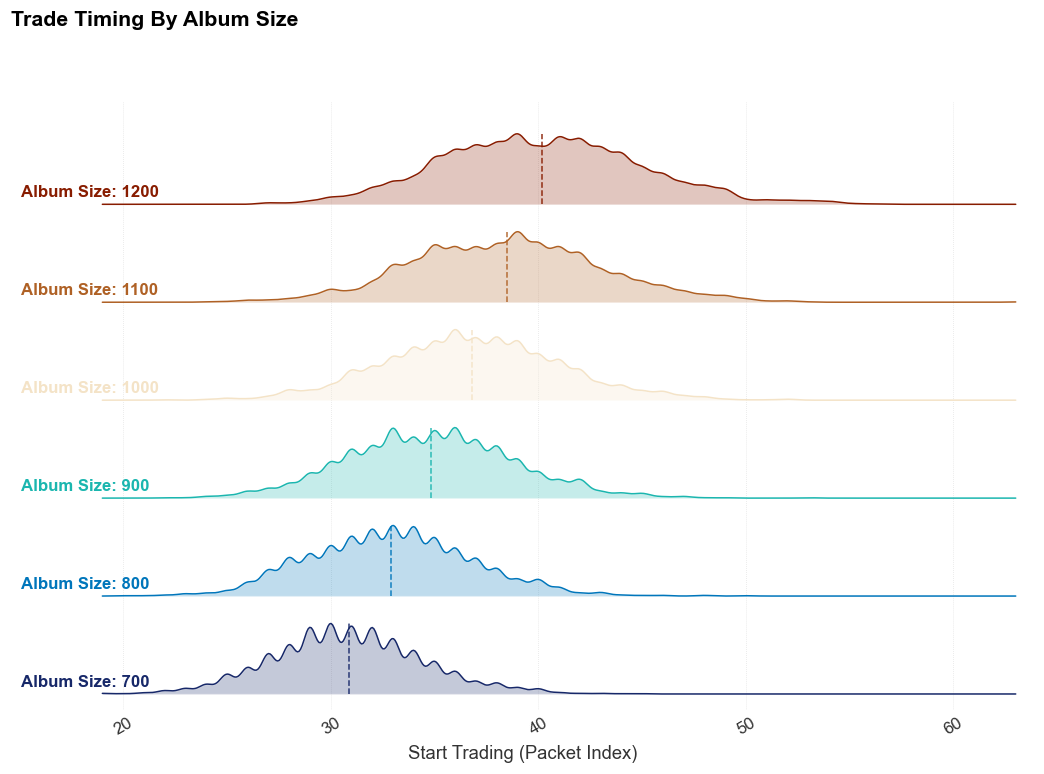

In [ ]:
ridgeplot_kde(
    results_df,
    group_col="len_album",
    value_col="start_trading",
    title="Trade Timing by Album Size",
    subtitle="",
    xlabel="Start Trading (# of Packets Bought)",
    bw_method=0.1,
    label_fmt=lambda g: f"Album Size: {g}",
    label_y_offset=0.15,     # increase if still too close (try 0.12–0.18)
    x_left_pad_frac=0.10,    # pushes x-axis start a bit further in
)

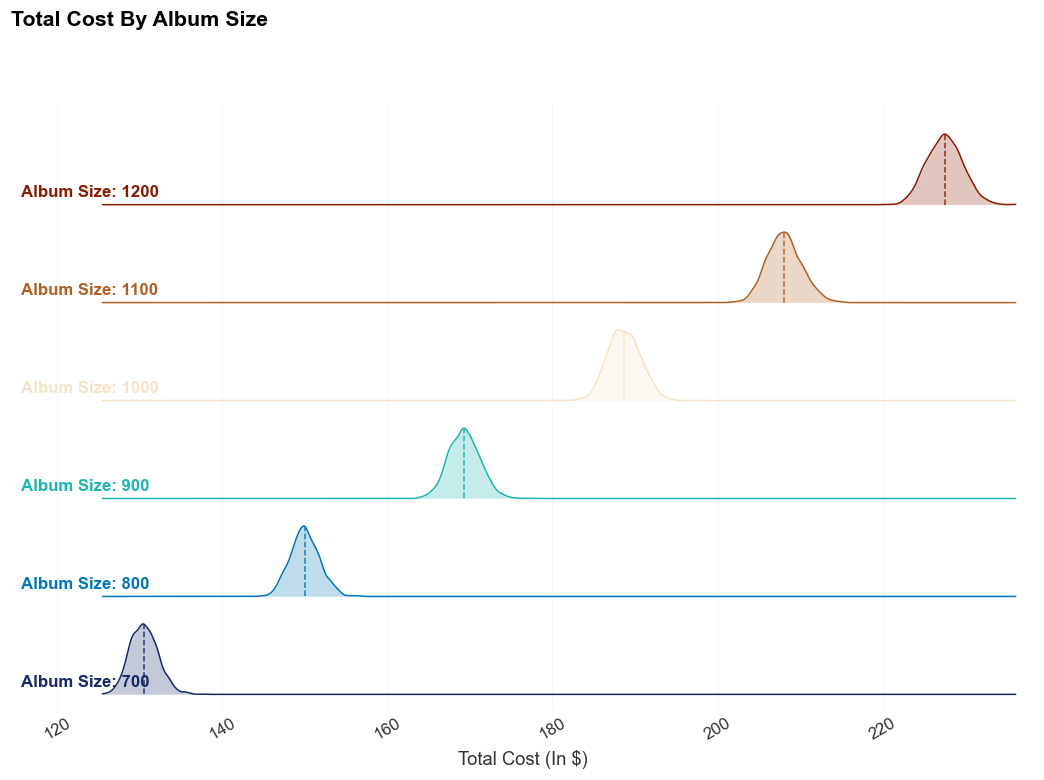

In [64]:
ridgeplot_kde(
    results_df,
    group_col="len_album",
    value_col="total_cost",
    title="Total Cost by Album Size",
    subtitle="",
    xlabel="Total Cost (in $)",
    bw_method=0.2,
    label_fmt=lambda g: f"Album Size: {g}",
    label_y_offset=0.15,     # increase if still too close (try 0.12–0.18)
    x_left_pad_frac=0.10,    # pushes x-axis start a bit further in
)
